# Segment 1

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string
from wordcloud import WordCloud,STOPWORDS
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import Dataset, DataLoader
import torch

In [3]:
train = pd.read_csv('train_data.csv')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## EDA for training the model

In [173]:
train.isna().sum()/len(train)

overall           0.000000
vote              0.771775
verified          0.000000
reviewTime        0.000000
reviewerID        0.000000
asin              0.000000
style             0.415202
reviewerName      0.000271
reviewText        0.000000
summary           0.000091
unixReviewTime    0.000000
dtype: float64

### Column  style

In [4]:
def format_style(style_list):
    import ast
    formatted_style = []
    for item in style_list:
        if pd.isna(item):
            formatted_style.append(np.nan)
        else:
            try:
                dct = ast.literal_eval(item)
                formatted_style.append(dct)
            except (ValueError, SyntaxError):
                formatted_style.append(np.nan)
    return pd.Series(formatted_style)

In [5]:
train['formatted_style'] = format_style(train['style'].tolist())

In [95]:
train.sample(10)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,formatted_style
680557,4,NaN,True,2017-12-16,A3IXNJB6KINPA5,B01DUDPKVW,NaN,LiteKid,Nice accessory to have w/ the ec power bank..k...,"good, but think could be tad better",1513382400,NaN
48909,5,NaN,True,2017-07-14,A8TP7ZWZLM88N,B001CY0P7G,NaN,Techmeister,We have a 500M Internet link and terminate it ...,Used in high speed firewall... Get full 500Mbp...,1499990400,NaN
307780,2,NaN,False,2016-01-25,A1340YWJVXDDJG,B00LVQ7KQO,{'Color:': ' White'},Shari Ogilvie,Nice little camera - but BUYER BEWARE! Their ...,Nice Camera - HORRIBLE Tech Support!,1453680000,{'Color:': ' White'}
72489,4,NaN,True,2016-11-22,A1C200FKZ2G1MM,B003INFE16,"{'Color:': ' GeminII M4', 'Style:': ' 4 Heat P...",TOYnn,Cooler Master GeminII M4 - Got this to help co...,Cooler Master GeminII M4 - Got this to help co...,1479772800,"{'Color:': ' GeminII M4', 'Style:': ' 4 Heat P..."
157562,4,2.0,True,2016-12-03,A2OUBA41X6OUOI,B00ATZJ606,{'Style:': ' 3-Outlet'},Puablo,"Great product in general, although a little bu...",Would be perfect if it didn't require both pow...,1480723200,{'Style:': ' 3-Outlet'}
545556,1,NaN,True,2017-12-11,A2NLDR3HX67T91,B015NO566A,"{'Size:': ' 17 - 55""'}",Edward,The only thing I don't like about this TV Wall...,POOR DESIGN TV WALL MOUNT,1512950400,"{'Size:': ' 17 - 55""'}"
387587,2,NaN,True,2017-04-03,A138DFZFRI9LAO,B00S8GU2OC,"{'Color:': ' White', 'Capacity:': ' 3.3 ft'}",hdfazz,"While this has the connectors I needed, I was ...",Seems undersized for use in charging your device.,1491177600,"{'Color:': ' White', 'Capacity:': ' 3.3 ft'}"
536109,5,NaN,True,2017-09-20,A2JWK56Q8BFE8D,B015401IWE,{'Color:': ' White/Purple'},Byrd,I build computers for a boutique custom comput...,Phenomenal case.,1505865600,{'Color:': ' White/Purple'}
371115,3,NaN,True,2017-02-05,A1KT4NOG05YT5J,B00QQ7SG48,"{'Size:': ' Max Download Speed: 172 Mbps', 'C...",revman,I'm on my second Arris SB6121 because the firs...,WORKS BUT!,1486252800,"{'Size:': ' Max Download Speed: 172 Mbps', 'C..."
820832,4,NaN,True,2018-08-10,A0289048PRWFY7ZXQKCD,B017PT8XRK,{'Color:': ' 2PACK Black M to F'},AC,I'm using these with as standard pair of headp...,"Stout, low profile",1533859200,{'Color:': ' 2PACK Black M to F'}


In [6]:
expanded_style = pd.json_normalize(train['formatted_style'])

In [177]:
expanded_style.isna().sum()/len(train)

Format:                                  0.993618
Color:                                   0.706507
Size:                                    0.841275
Style:                                   0.828985
Length:                                  0.988571
style:                                   0.997899
Package Type:                            0.970674
Product Packaging:                       0.988983
Capacity:                                0.956019
Model:                                   0.991103
Model Number:                            0.999226
Color Name:                              0.998229
Size Name:                               0.997996
Item Package Quantity:                   0.998837
Package Quantity:                        0.997410
Style Name:                              0.994015
style name:                              0.999362
Grip Type:                               0.999487
Configuration:                           0.992345
Edition:                                 0.999337


In [7]:
# color related
expanded_style['color'] = (
    expanded_style['Color:']
    .fillna('') + ' ' +
    expanded_style['Color Name:'].fillna('') + ' ' +
    expanded_style['Colorj:'].fillna('') + ' ' +
    expanded_style['Colour:'].fillna('')
).str.strip() 
expanded_style = expanded_style.drop(columns=['Color:', 'Color Name:', 'Colorj:', 'Colour:'])

# packaging-related 
expanded_style['packaging'] = (
    expanded_style['Package Type:'].fillna('') + ' ' +
    expanded_style['Product Packaging:'].fillna('') + ' ' +
    expanded_style['Item Package Quantity:'].fillna('') + ' ' +
    expanded_style['Package Quantity:'].fillna('')
).str.strip()
expanded_style = expanded_style.drop(columns=['Package Type:', 'Product Packaging:', 'Item Package Quantity:', 'Package Quantity:'])

In [8]:
consolidations = {
    'format': ['Format:'],
    'size': ['Size:', 'Size Name:'],
    'style': ['Style:', 'style:', 'Style Name:', 'style name:'],
    'length': ['Length:', 'Length Range:', 'Item Display Length:'],
    'capacity': ['Capacity:'],
    'model': ['Model:', 'Model Number:'],
    'grip_type': ['Grip Type:'],
    'configuration': ['Configuration:'],
    'edition': ['Edition:'],
    'offer_type': ['Offer Type:'],
    'pattern': ['Pattern:'],
    'width': ['Width:'],
    'shape': ['Shape:'],
    'service_plan_term': ['Service plan term:'],
    'metal_type': ['Metal Type:'],
    'design': ['Design:'],
    'platform': ['Platform:', 'Platform for Display:'],
    'number_of_items': ['Number of Items:'],
    'material_type': ['Material Type:'],
    'processor_description': ['processor_description:', 'Processor Description:'],
}

for new_col, cols_to_merge in consolidations.items():
    expanded_style[new_col] = expanded_style[cols_to_merge].fillna('').agg(' '.join, axis=1).str.strip()
    expanded_style.drop(columns=cols_to_merge, inplace=True)

In [9]:
expanded_style =expanded_style.replace('', np.nan)

In [10]:
color_list = ['red', 'green', 'blue', 'black', 'white', 'yellow', 'brown', 'gray', 'pink',
    'orange', 'purple', 'violet', 'cyan', 'magenta', 'teal', 'silver', 'gold',
    'beige', 'maroon', 'olive', 'navy', 'turquoise', 'indigo', 'coral', 'peach', 'rose gold']

In [182]:
all_colors = set(
    color.strip() for entry in expanded_style['color'].str.lower().dropna()
    for color in entry.split('/')
)
unmatched_color = list(all_colors - set(color_list))

In [183]:
unmatched_color

['',
 'red-with ews',
 'lens cleaning pen',
 't adapter for olumpus panasonic m4',
 'android car dvd with remote control',
 '6pk 12mm combo set',
 '1 meter usb & hdmi',
 'black tulip',
 'z- blossom',
 'cat',
 'ml06b',
 'yellow + blue',
 'd.f.pressure',
 'fixed bullet with 16gb micro sd',
 '3) 10 x 8gb',
 '21.5"p 16:9 -anti glare filter',
 'gold-silver',
 'gold,silver,gray(10ft)',
 'black with chrome handle',
 'aux cable',
 'ws300g',
 '4" (5pcs)',
 'zd-keyborad case navy',
 '0.9 meter',
 'hp-39c',
 'b-navy',
 '13 inch-logic pro x',
 'italy',
 '003 pink',
 '3 mega pixels',
 'white - 10 pack',
 'style1_dark grey',
 'nex-n216 (black)',
 'urban navy heather',
 '5.7ft-retractable white',
 'dark grey(2',
 'elephant print',
 'eba01b',
 'za-leopard_b',
 'dual-cam clamp',
 'black x3',
 'g2 gold',
 'black with gate',
 'zd- silicone red',
 'camouflage green color',
 'd.f.vegas duo',
 'penguin',
 'black (sg05-lite)',
 'dp to hdmi 4k',
 'vb201p',
 'black type-c',
 '988 blue',
 'double-c handle',
 'a

In [11]:
def validate_color(value):
    import re
    if isinstance(value, str):
        value_lower = value.lower()
        color_pattern = r'\b(' + '|'.join(re.escape(color) for color in color_list) + r')\b'
        
        match = re.search(color_pattern, value_lower)
        if match:
            return match.group(0)
    return np.nan

In [12]:
expanded_style['color'] = expanded_style['color'].apply(validate_color)

In [186]:
expanded_style.color.isna().sum()/len(train)

0.7803667467673647

In [13]:
train = pd.concat([train, expanded_style.color], axis=1)

In [14]:
train = train.drop(columns=['style','formatted_style'])

In [191]:
train.sample(10)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,color
490171,2,NaN,True,2017-06-23,AIHUU9212GE9I,B011BIIO9I,Boston Chris,I bought two of these as replacements for tire...,"In head to haed test, these are inferior to or...",1498176000,NaN
548019,5,NaN,True,2016-08-28,A273UDQQ3EX6HJ,B015PS3ME2,ChrisB,"So far, I am very pleased with this unit. It ...",Poke-hatching good,1472342400,NaN
132469,2,NaN,True,2016-07-25,AIHVEJM3OYE4M,B0080JIVC2,urabus,I loved it last month when I first received it...,I loved it last month when I first received it,1469404800,NaN
816458,5,NaN,True,2018-03-19,A1UZCYUNTI4C32,B015F6ODUQ,Nick Ugolini,I have a mid 2011 iMac which only USB 2 ports ...,Couldnt be more pleased with the result on a M...,1521417600,NaN
426352,1,2.0,True,2017-03-03,A1ED6GYNJ1MK1L,B00VE0KKR8,Ducrab,"Upon receiving my brand new DY-60N, I noticed ...",Exposed lubricant?,1488499200,NaN
333012,5,NaN,True,2016-12-20,A2CVGIE2X8Q1OI,B00NI45AUU,Tech Fan,Can't ask for better overall right now. It's w...,Incredible value,1482192000,NaN
549605,3,NaN,False,2017-05-12,A274XSPB6GC6C2,B015R7AFVE,GRM,Wireless Range/Audio Playback Quality:\nOver t...,"Pretty good sound when plugged in, but the wir...",1494547200,NaN
631553,4,9,True,2016-04-15,A6TT44CQTSNMO,B01B18Y4Z6,David Mendelsohn,"First, let me give 5 solid starts to vendor Fr...",Not perfect but a terrific value,1460678400,NaN
774972,5,NaN,True,2017-01-27,A32LVZZXB5F5MS,B00G66EDOG,SKY,I purchased a couple of these a few years ago ...,Excellent Case!,1485475200,NaN
400173,4,NaN,True,2017-09-02,A3HMC4XSENYVXE,B00T5XQE3U,RustyB,Works pretty slick. Kids in car can watch dif...,Great little device,1504310400,black


### Column verified


In [162]:
# the fake review detection is not the topic of this project so ...
train['verified'].value_counts() / len(train)

verified
True     0.858685
False    0.141315
Name: count, dtype: float64

<Axes: xlabel='verified', ylabel='count'>

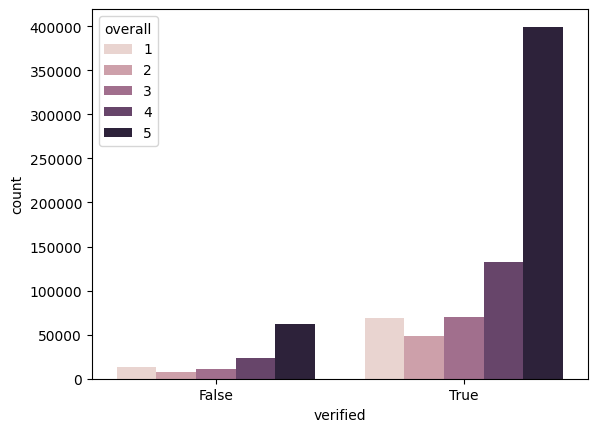

In [134]:
sns.countplot(x='verified', hue="overall", data=train)

### Column reviewTime

In [15]:
train['reviewTime'] = pd.to_datetime(train['reviewTime'], errors='coerce') 
train['year'] = train['reviewTime'].dt.year
train['month'] = train['reviewTime'].dt.month

In [16]:
train = train.drop(columns=['reviewTime'])
train.sample(5)

,overall,vote,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,color,year,month
687695,4,NaN,True,ACS10ZOB8XCGO,B01E8I6E8Q,Jazzman,Great flash. I love the hotshot locking system...,"Nice flash, wonderful light. Great low cost al...",1481760000,NaN,2016,12
212098,5,4.0,True,A1U7W7741PDA4,B00ESVCRJO,SethX,I wanted something simple. I used to have Life...,Right Price - Great Product - No Hub Required ...,1487894400,NaN,2017,2
584188,5,NaN,True,A3MOI7EB37ELAT,B017P34XUC,Marvid,I have this ethernet cable running from the do...,Perfect for what I needed!,1527638400,NaN,2018,5
342956,5,NaN,True,A2MP1N5P1BDQ82,B00O4UJHFG,Adam M. Rice,I have struggled for years to find endpoint VP...,Rock solid VPN tunnels,1488672000,NaN,2017,3
281863,4,NaN,False,A2WB4OWBUH2VQX,B00K7809QU,HardyBoy64,This backpack is VERY well made. The material ...,Very well made,1456704000,indigo,2016,2


<Axes: xlabel='year', ylabel='count'>

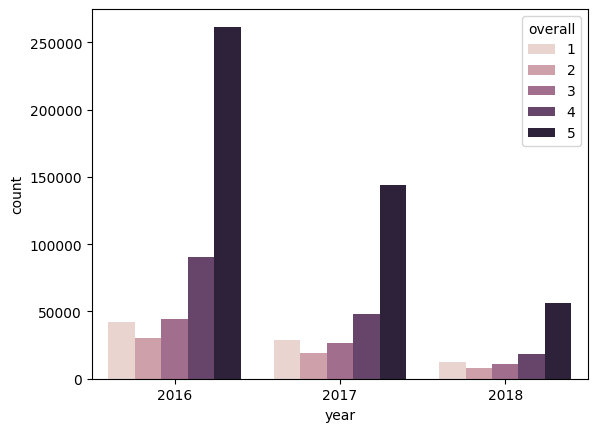

In [136]:
sns.countplot(x='year',hue='overall', data=train)

### Columns reviews

In [17]:
train['reviews'] = train['reviewText'] + train['summary']
train = train.drop(['reviewText', 'summary'], axis=1)

In [18]:
def review_cleaning(text):
    import re
    import string
    text = str(text).lower()
    text = re.sub('\n', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [19]:
train['reviews'] = train['reviews'].apply(lambda x: review_cleaning(x))
train['reviews'] = train['reviews'].astype(str)
train['reviews'].replace("nan", np.nan, inplace=True)
train = train.dropna(subset=['reviews']).reset_index(drop=True)
# delete repetitive reviews
train = train.drop_duplicates(subset='reviews')
train.reset_index(drop=True, inplace=True)

### Column vote

In [195]:
train.vote.value_counts()

vote
2.0      37154
2        23461
3.0      18256
3        13312
4.0      10153
         ...  
367          1
132          1
283.0        1
392          1
284.0        1
Name: count, Length: 861, dtype: int64

In [20]:
def vote_cleaning(txt):
  import re
  txt = str(txt)
  txt = txt.replace(',', '')
  txt = re.sub(r'\b(\d+)(?:\.0)?\b', r'\1', txt)
  return int(txt)

In [21]:
train['vote'] = train['vote'].fillna(0)
# vote -> clean and uint64
train['vote'] = train['vote'].apply(vote_cleaning)
train.vote.value_counts()

vote
0      621930
2       66052
3       34524
4       20217
5       13287
        ...  
215         1
970         1
457         1
583         1
783         1
Name: count, Length: 474, dtype: int64

In [202]:
train.to_csv('model_ready_data.csv')

## Q1

In [271]:
train['overall'].value_counts() / len(train)

overall
5    0.549578
4    0.187124
1    0.098588
3    0.096924
2    0.067787
Name: count, dtype: float64

Text(0, 0.5, 'Count')

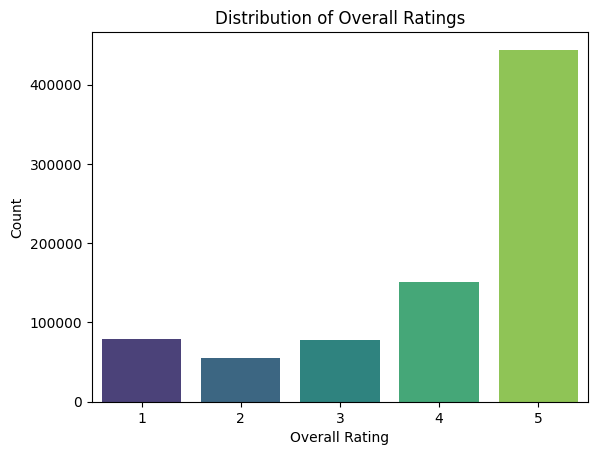

In [272]:
sns.countplot(x='overall', data=train,palette='viridis')
plt.title('Distribution of Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Count')

## Q2

In [273]:
train['sentiment'] = np.where(train['overall'].isin([4, 5]), 'positive', np.where(train['overall'].isin([1, 2]), 'negative', 'neutral'))

In [274]:
positive_reviews = train[train['sentiment'] == 'positive'].reviews
neutral_reviews = train[train['sentiment'] == 'neutral'].reviews
negative_reviews = train[train['sentiment'] == 'negative'].reviews

In [275]:
print(f'percentage of positive reviews: {len(positive_reviews) * 100 /len(train)}')
print(f'percentage of neutral reviews: {len(neutral_reviews) * 100 /len(train)}')
print(f'percentage of negative reviews: {len(negative_reviews) * 100 /len(train)}')

percentage of positive reviews: 73.67017064576157
percentage of neutral reviews: 9.692362513362632
percentage of negative reviews: 16.637466840875796


Text(0.5, 1.0, 'Sentiment Distribution in Training Data')

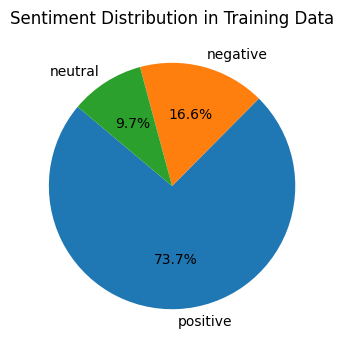

In [280]:
sentiment_counts = train['sentiment'].value_counts()
labels = sentiment_counts.index 
sizes = sentiment_counts.values 

plt.figure(figsize=(4,4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in Training Data')

In [278]:
train.reviews = train.reviews.str.lower()

In [329]:
stop_words = {
    'yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 'will','still','day',
    'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other', 'im','first','mouse',
    'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 'even', 'seem','see',
    'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', 'monitor', 'devices', 'found',
    'very', 'should', 'any', 'y', 'isn', 'who', 'a', 'they', 'to', 'too', "should've", 'has', 'before', 'bought', 'buy','know',
    'into', 'yours', "it's", 'do', 'against', 'on', 'now', 'her', 've', 'd', 'by', 'am', 'from', 'wire','may','come', 'run',
    'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such', 'work','works','worked',
    'his', 'himself', 'ourselves', 'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 'version', 'speakers','said',
    'me', 'why', 'once', 'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it', 'though','headphones','find',
    'at', 'after', 'its', 'which', 'there', 'our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under', 'button', 'using','came',
    'over', 'again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all', 'etc', 'radio', 'thinking','make', 'comes',
    'case', 'camera', 'device', 'usb', 'port', 'issue', 'thing', 'cable', 'keyboard', 'screen', 'one', 'two', 'used','needed','need',
    'use', 'headphone', 'phone', 'unit', 'product', 'products', 'drive', 'battery', 'hard drive', 'set', 'sound','think', 'adapter',
    'stuff', 'system', 'bluetooth', 'antenna', 'issues', 'tv', 'television', 'box', 'part', 'parts', 'thats', 'computers', 'actually',
    'things', 'tablet', 'video', 'power','moniter','got','speaker','bottun','laptop','computer','time','card','key','sure',
}

In [330]:
train['reviews'] = train['reviews'].apply(
    lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words]) if isinstance(x, str) else x)

In [323]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='black', max_words=100,font_path="/usr/share/fonts/truetype/DejaVuSans-Bold.ttf").generate(text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

In [331]:
positive_reviews = train[train['sentiment'] == 'positive'].reviews
neutral_reviews = train[train['sentiment'] == 'neutral'].reviews
negative_reviews = train[train['sentiment'] == 'negative'].reviews

In [332]:
negative_reviews_text = ' '.join(negative_reviews.dropna().astype(str))
positive_reviews_text = ' '.join(positive_reviews.dropna().astype(str))
neutral_reviews_text = ' '.join(neutral_reviews.dropna().astype(str))

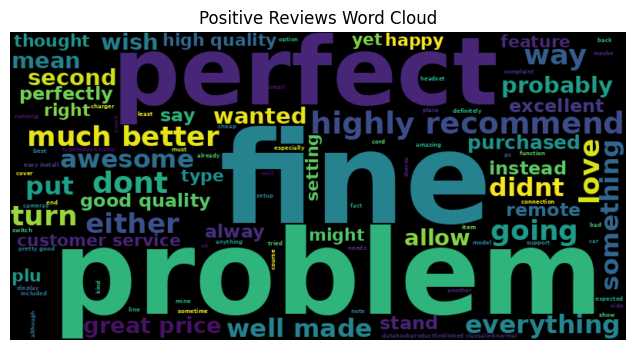

In [333]:
generate_wordcloud(positive_reviews_text, 'Positive Reviews Word Cloud')

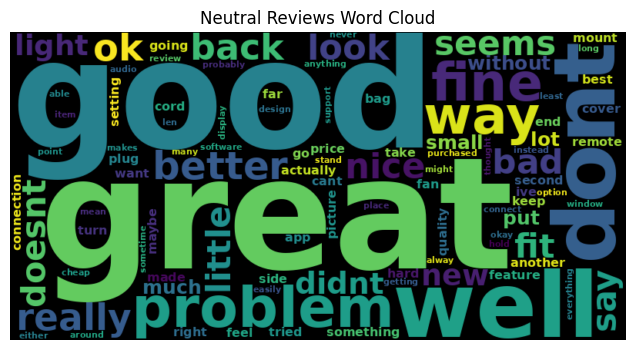

In [326]:
generate_wordcloud(neutral_reviews_text, 'Neutral Reviews Word Cloud')

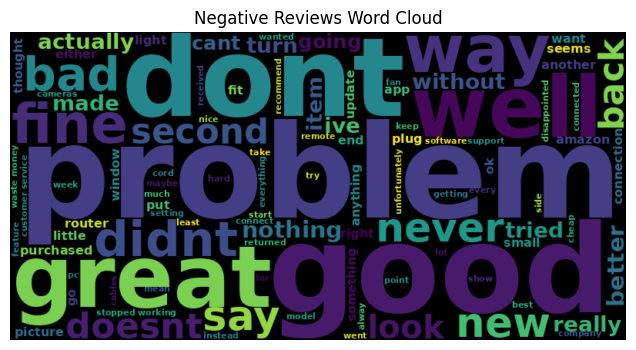

In [327]:
generate_wordcloud(negative_reviews_text, 'Negative Reviews Word Cloud')

## Q3

In [334]:
train.vote.value_counts() / len(train)

vote
0      0.769502
2      0.081725
3      0.042716
4      0.025014
5      0.016440
         ...   
215    0.000001
970    0.000001
457    0.000001
583    0.000001
783    0.000001
Name: count, Length: 474, dtype: float64

In [335]:
user_votes = train.groupby('reviewerName')['vote'].sum().reset_index()
top_10_users = user_votes.sort_values(by='vote', ascending=False).head(10)

In [336]:
top_10_users.to_csv('top_ten_user.csv',index=False)

## Q4

In [350]:
train_q4 = pd.read_csv('train_data.csv')
train_q4 = train_q4.drop_duplicates(subset='reviewText')
train_q4['reviewText'].replace("nan", np.nan, inplace=True)
train_q4 = train_q4.dropna(subset=['reviewText'])
train_q4.reset_index(drop=True, inplace=True)

In [352]:
train_q4['review_length'] = train_q4['reviewText'].apply(lambda x: len(str(x)))
print(f'max length : {train_q4.review_length.max()}')
print(f'min length : {train_q4.review_length.min()}')

max length : 29146
min length : 200


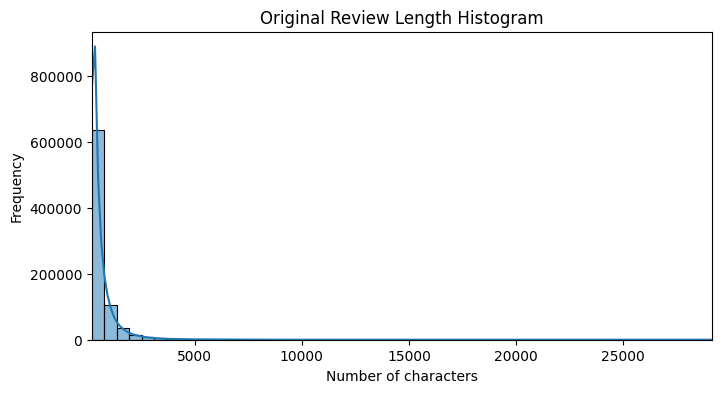

In [355]:
plt.figure(figsize=(8, 4))
sns.histplot(train_q4['review_length'], bins=50, kde=True)
plt.title('Original Review Length Histogram')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.xlim(200,29146)
plt.show()

In [357]:
Q1 = train_q4['review_length'].quantile(0.1)
Q9 = train_q4['review_length'].quantile(0.9)
mode = train_q4['review_length'].mode()
print(f"Q1: {Q1}")
print(f"Q9: {Q9}")
print(f"Median: {train_q4['review_length'].median()}")
print(f"mode: {mode}")

Q1: 227.0
Q9: 1223.0
Median: 409.0
mode: 0    203
Name: review_length, dtype: int64


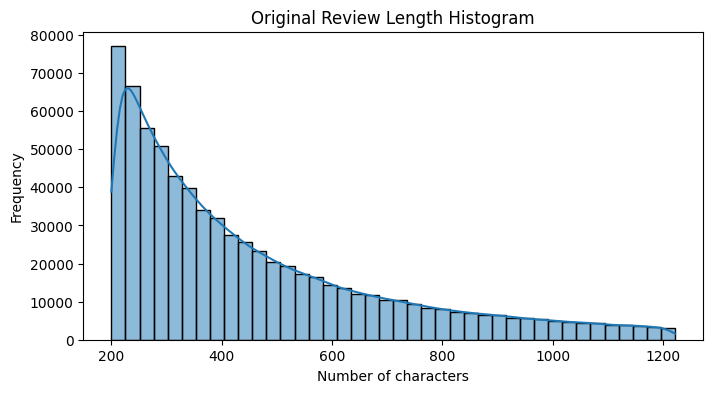

In [358]:
filtered_reviews = train_q4[train_q4['review_length'] < Q9]
plt.figure(figsize=(8,4))
sns.histplot(filtered_reviews['review_length'], bins=40, kde=True)
plt.title('Original Review Length Histogram')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.show()

## Q5

In [22]:
brand = pd.read_csv('title_brand.csv')
rating_counts = train.groupby('asin')['overall'].value_counts().unstack(fill_value=0)
rating_counts.head()

overall,1,2,3,4,5
asin,,,,,
0101635370,2,0,1,0,1
0380709473,0,0,0,1,0
0511189877,0,1,0,1,2
0528881469,1,0,0,0,1
0545105668,0,0,0,0,1


In [23]:
rating_counts = rating_counts.merge(brand, on='asin', how='left')
rating_counts.sample(5)

,asin,1,2,3,4,5,title,brand
11164,B001PGXEH4,2,0,3,1,4,Sigma 18-250mm f/3.5-6.3 DC OS HSM IF Lens for...,Sigma
51504,B00NPS0RES,0,0,0,0,1,Bear Motion for New Fire HD 6 Tablet - Premium...,Bear Motion
5456,B0009JR456,0,0,0,0,1,Peerless ST650 Universal Tilt Wall Mount For 3...,Peerless
42098,B00IPNR64M,1,0,0,1,1,"C&amp;E CNE40292 6 Feet, 1/4-Inch Stereo Audio...",C&E
18346,B0057OCDQS,3,0,4,2,4,Garmin Nuvi 50LM Navigator,Garmin


In [24]:
rating_counts = rating_counts[[5,'brand','title']]
rating_counts = rating_counts.sort_values(by=5, ascending=False).head(10)
rating_counts

,5,brand,title
67162,1163,Cambridge Soundworks,OontZ Angle 3 Enhanced Stereo Edition IPX5 Spl...
46646,659,NETGEAR,NETGEAR N300 WiFi Range Extender (EX2700)
85395,600,Roku,Roku Streaming Stick (3600R) - HD Streaming Pl...
15108,552,Logitech,Logitech M570 Wireless Trackball Mouse &ndash;...
52470,527,Samsung,Samsung 850 EVO 500GB 2.5-Inch SATA III Intern...
53743,433,"Arlo Technologies, Inc",Arlo - Wireless Home Security Camera System | ...
52429,427,Samsung,Samsung 850 EVO 250GB 2.5-Inch SATA III Intern...
30100,413,Sabrent,Sabrent 4-Port USB 2.0 Hub with Individual Pow...
14007,401,Cooler Master,Cooler Master Vortex Plus - CPU Cooler with Al...
75233,400,Anker,Anker Soundcore Bluetooth Speaker with Loud St...


In [25]:
rating_counts.to_csv('Q5.csv')

## Q6

In [345]:
vote_counts = train[['asin','vote','overall']]
vote_counts = vote_counts.merge(brand, on='asin', how='left')
vote_counts.sample()

,asin,vote,overall,title,brand
338443,B00NQNI3FW,0,5,Fintie Case for Kindle Voyage - [The Thinnest ...,Fintie


In [346]:
vote_counts_br = vote_counts.groupby('brand')['vote'].sum().reset_index()
vote_counts_br = vote_counts_br.sort_values(by='vote',ascending=False)

In [347]:
vote_counts_br = vote_counts_br.head(10)
vote_counts_br

,brand,vote
10415,Samsung,55613
10916,Sony,39405
1091,Asus,28486
2395,Canon,25277
6829,LG,21913
790,AmazonBasics,17848
550,Acer,17204
11500,TP-LINK,16514
3272,Dell,15922
4867,Garmin,14891


In [348]:
vote_counts_br['avg overall'] = vote_counts_br['brand'].map(vote_counts.groupby('brand')['overall'].mean())
vote_counts_final = vote_counts_br.sort_values(by='avg overall', ascending=False)
vote_counts_final

,brand,vote,avg overall
2395,Canon,25277,4.406531
790,AmazonBasics,17848,4.206365
550,Acer,17204,4.055485
10415,Samsung,55613,3.936207
10916,Sony,39405,3.935500
11500,TP-LINK,16514,3.930856
6829,LG,21913,3.872014
3272,Dell,15922,3.862551
1091,Asus,28486,3.852611
4867,Garmin,14891,3.813415


In [349]:
vote_counts_final[['brand','avg overall']].to_csv('Q6.csv')

# Segment 2

In [359]:
all_relevent_words = set()

In [365]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

synonyms_war_fasttext = ft.get_nearest_neighbors('warranty')
synonyms_gar_fasttext = ft.get_nearest_neighbors('guarantee')

 (100.00%) [==================================================>]                                                 ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]> 

In [366]:
for w in synonyms_gar_fasttext:
  all_relevent_words.add(w[1])

for w in synonyms_war_fasttext:
  all_relevent_words.add(w[1])

In [360]:
from gensim.models import KeyedVectors
model2 = KeyedVectors.load_word2vec_format('~/Desktop/roberta/googleVectors/GoogleNews-vectors-negative300.bin', binary=True)

synonyms_war_gensim = model2.most_similar('warranty', topn=20)
synonyms_gar_gensim = model2.most_similar('guarantee', topn=20)

In [361]:
for w in synonyms_gar_gensim:
  all_relevent_words.add(w[0])

for w in synonyms_war_gensim:
  all_relevent_words.add(w[0])

In [ ]:
from PyDictionary import PyDictionary

dictionary = PyDictionary()

synonyms_war_dict = dictionary.synonym("warranty")
synonyms_gar_dict = dictionary.synonym("guarantee")

In [369]:
# APIs Thesaurus.com or Datamuse to get synonyms based on user-defined queries

import requests

def get_synonyms(word):
    response = requests.get(f'https://api.datamuse.com/words?rel_syn={word}')
    return response.json()

synonyms_war_dm = get_synonyms('warranty')
synonyms_gar_dm = get_synonyms('guarantee')
print(f'synonyms of warranty: {synonyms_war_dm}')
print(f'synonyms of garantee: {synonyms_gar_dm}')

synonyms of warranty: [{'word': 'guarantee', 'score': 2461}, {'word': 'warrant', 'score': 2243}]
synonyms of garantee: [{'word': 'ensure', 'score': 3767}, {'word': 'warrant', 'score': 2243}, {'word': 'secure', 'score': 2071}, {'word': 'assure', 'score': 1924}, {'word': 'undertake', 'score': 1894}, {'word': 'insure', 'score': 1313}, {'word': 'warranty', 'score': 1084}, {'word': 'vouch', 'score': 1024}, {'word': 'guaranty', 'score': 730}]


In [370]:
for entry in synonyms_war_dm:
    all_relevent_words.add(entry['word'])
for entry in synonyms_gar_dm:
    all_relevent_words.add(entry['word'])

In [371]:
all_relevent_words_pd = pd.DataFrame(all_relevent_words)
all_relevent_words_pd.to_csv('all_relevent_words.csv')

In [29]:
all_relevent_words_pd = pd.read_csv('all_relevent_words.csv')
all_relevent_words_pd

,Unnamed: 0,0
0,0,assure
1,1,guaranteed
2,2,secure
3,3,vouch
4,4,guaranteeing
5,5,garantee
6,6,ADSI_cautions
7,7,Disclaimer_Past_performance
8,8,warrenty
9,9,Limited_Warranty


In [33]:
all_relevent_words

0                          assure
1                      guaranteed
2                          secure
3                           vouch
4                    guaranteeing
5                        garantee
6                   ADSI_cautions
7     Disclaimer_Past_performance
8                        warrenty
9                Limited_Warranty
10                        warrany
11                         insure
12                    ##-year/###
13                      gurantees
14                     guaranteee
15                      warranty.
16                       Warranty
17            extended_warranties
18                         ensure
19                        waranty
20                     Guaranteed
21                     warranties
22                        assures
23                     warrantees
24                      warrantee
25                      gaurantee
26                     warranty.I
27                        warrant
28                      assurance
29            

In [32]:
all_relevent_words = all_relevent_words_pd['0']

In [30]:
reviews = pd.DataFrame(train.reviews)

In [376]:
relevant_reviews_simple = reviews[reviews.reviews.str.contains(r'waranty|guarantee', case=False, na=False)]
len(relevant_reviews_simple)/len(reviews)

0.0029422536326562934

In [34]:
patterns = '|'.join(all_relevent_words)
relevant_reviews = reviews[reviews.reviews.str.contains(patterns, case=False, na=False)]
relevant_reviews.sample(5)

,reviews
775781,if you think getting two devices will allow yo...
379784,i cant really add anything to reviews that alr...
359073,this case for the macbook pro was one of the n...
268141,bought these as a gift for my teenage son one ...
497772,i have a few tablets and in the past i didnt u...


In [375]:
len(relevant_reviews)/len(reviews)

0.05393059349883201

In [66]:
s2_df = train[train['reviews'].isin(relevant_reviews.reviews)]

In [67]:
s2_df.overall = s2_df.overall.astype(float)
s2_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43588 entries, 25 to 808199
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         43588 non-null  float64
 1   vote            43588 non-null  int64  
 2   verified        43588 non-null  bool   
 3   reviewerID      43588 non-null  object 
 4   asin            43588 non-null  object 
 5   reviewerName    43575 non-null  object 
 6   unixReviewTime  43588 non-null  int64  
 7   color           10081 non-null  object 
 8   year            43588 non-null  int32  
 9   month           43588 non-null  int32  
 10  reviews         43588 non-null  object 
dtypes: bool(1), float64(1), int32(2), int64(2), object(5)
memory usage: 3.4+ MB


In [83]:
average_rating_by_product = s2_df.groupby('asin').agg({
    'overall': 'mean',
    'reviews': lambda x: ' AND '.join(x)  
})

average_rating_by_product_df = pd.DataFrame({
    'asin': average_rating_by_product.index,
    'avg_overall': average_rating_by_product['overall'],
    'all_reviews': average_rating_by_product['reviews']
}).reset_index(drop=True)

average_rating_by_product_df.sample(10)

,asin,avg_overall,all_reviews
11306,B00SZTR3UI,3.000000,overall i like the product it appears to be we...
9219,B00MVNBT36,3.000000,i wanted to use a monopod for a digital slr ca...
15748,B016D5FOFQ,5.000000,worked great for my living room the white matc...
10349,B00PRSY88U,2.000000,this cord organizer was just ok for me i found...
8935,B00M77HLII,4.750000,good speed plugnplay for a lenovo yoga book wh...
4354,B00AM7MM4I,1.000000,dont buy they have an issue where the hinge co...
20603,B01G5BRML2,5.000000,this charger is so great we as many other youn...
9190,B00MSTG93S,4.142857,worked perfectly on a visit to chswitzerland a...
5705,B00E3EAMKW,1.000000,so i purchased a year warranty for my laptop t...
14173,B012MA4W5O,5.000000,product zozo universal laptop charger ac adapt...


In [85]:
average_rating_by_product_df.sample(10)

,asin,avg_overall,all_reviews
1496,B0029U15GC,1.500000,this worked for me for about a year and a half...
8919,B00M5BX5P4,2.333333,just keep looking for nowas other owners have ...
3802,B008MDOTUE,4.000000,i like this frame a lot nice resolution and i ...
15131,B01551U3JG,3.000000,update magnet had shifted on my snugg case and...
17775,B01ALG2PNM,4.000000,great case very secure and very durable only c...
9511,B00NIYNUXO,1.000000,i have bought gopro cameras a gopro gopro and ...
16346,B017K42FVA,5.000000,after giving one star to this gimbal because i...
6535,B00GH7TKVK,4.000000,im somewhat confused about who really makes th...
18935,B01CYNT6OG,5.000000,this pen stylus from dimples excel has a metal...
6109,B00F415LEU,2.000000,my review has changed again and not due to the...


In [86]:
# join on asin
average_rating_by_product_df_brand = average_rating_by_product_df.merge(brand, on='asin', how='left')
average_rating_by_product_df_brand.sample(5)

,asin,avg_overall,all_reviews,title,brand
8651,B00KOAQFYG,4.0,bought this in order to dry uv glue on cell ph...,NuLink UV Ultraviolet Light Lamp 36 Watt Dryer...,NuLink
70,B00004Z5D5,5.0,if youre networking an old offline computer wi...,Belkin 10-Foot CAT5e Crossover Molded Networki...,Belkin
906,B000EXZ0V2,5.0,i was initially very skeptical of the berhyped...,Happy Hacking Keyboard Professional2 (White),Happy Hacking Keyboard
18438,B01B4BKJOK,3.0,ive been looking for a ip camera for a while n...,Reolink IP PoE Security Camera 4 Megapixels Su...,REOLINK
17832,B019YW0UD6,5.0,this is awesome i had a headset in a similar s...,FKANT Bluetooth Neckband Headset Super Long Ba...,FKANT


In [89]:
average_rating_by_product_df_brand_final = average_rating_by_product_df_brand[['avg_overall','title','brand','all_reviews']]
average_rating_by_product_df_brand_final.sample(10)

,avg_overall,title,brand,all_reviews
7147,4.0,D-Link Systems 20-Port SmartPro Stackable Swit...,D-Link,this is a pretty good switch for the price eas...
20909,5.0,"Sport Earphones, DTFDTW Stereo Earphones In-Ea...",DTFDTW,i received this item fast once ordered the ear...
21648,5.0,Dmax Armor for LG G Pad X 10.1 Screen Protecto...,Dmax Armor,my son breaks everything have that in other re...
3140,3.0,StudioFX 2000 WATT Digital Photography Continu...,StudioFX,they would be better if they were just left in...
15471,4.0,Open-Mesh MR1750 Dual Band 802.11ac Access Point,Open-Mesh,minute setup and used same ssid from old rout...
641,5.0,C2G 27397 14 Inch Internal Power Extension Cab...,C2G,pleasure your pc instantly by adding long flex...
16911,1.0,Lumex Technologies LED Mini Portable Pico Vide...,Lumex Technologies,started out ok i originally hoped to use this ...
8231,5.0,Fujifilm TCL-X100S Telephoto Conversion Lens f...,Fujifilm,there was insufficient information on various ...
14562,2.0,"iPad 2, 3, 4 Screen Protector Glass, amFilm Gl...",amFilm,i received cracked due to shipping first time ...
3204,2.5,Toshiba Canvio 750 GB USB 3.0 Basics Portable ...,Toshiba,i purchased this so i could personally back up...


In [90]:
s2_final_df = average_rating_by_product_df_brand_final.sort_values(by='avg_overall',ascending=False)

In [92]:
s2_final_df.head(10)

,avg_overall,title,brand,all_reviews
0,5.0,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...",VideoSecu,only issue so far is the hinges are firm but t...
11710,5.0,Cable Matters 10Gb 40Gb Multimode Duplex 50/12...,Cable Matters,these work very nicely they fit well and the s...
11690,5.0,Canon EF 11-24mm f/4L USM Lens,Canon,thank you canon youve acheived the impossible ...
11691,5.0,Canon Battery Grip BG-E18,Canon,i looked at many different models by many diff...
11693,5.0,BOSS Audio MCBK400 Weatherproof Speaker / Ampl...,BOSS Audio Systems,i bought these speakers to install on my kawas...
11696,5.0,Smatree 4-in-1 Aluminum Thumbscrew Accessories...,Smatree,this solid aluminum unit replaces the plastic ...
11698,5.0,Rokinon 135mm F2.0 ED UMC Telephoto Lens for N...,Rokinon,the other reviews are sound this is a great le...
11704,5.0,Sevenoak Photography Electronic Camera Tripod ...,Sevenoak,this item is incredibly useful for timelapse p...
11706,5.0,Symphonized NRG Premium Genuine Wood in-Ear No...,Symphonized,i love my headsets its mic is clear and the mu...
11707,5.0,"Harman Kardon SOHO White Premium, On-Ear Heads...",Harman Kardon,in general i had a very good experience with h...


In [93]:
s2_final_df.to_csv('Segment2.csv',index = False)

# Segment 3

## Visualizing Data

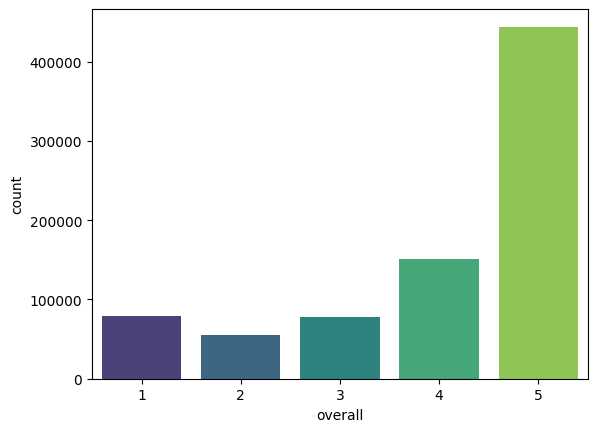

In [204]:
sns.countplot(x='overall', data=train, palette='viridis')
plt.show()

<Axes: title={'center': 'words per review'}, xlabel='overall'>

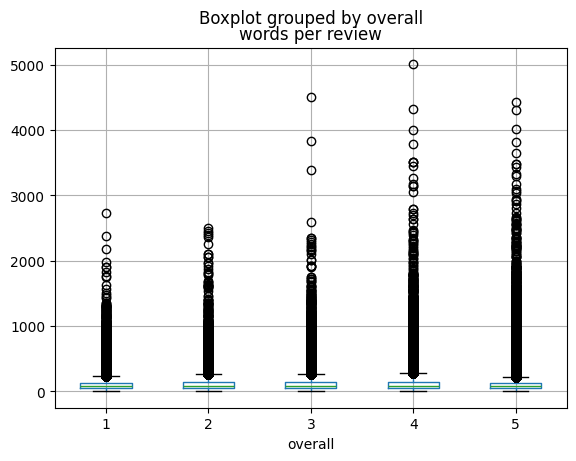

In [205]:
train['words per review'] = train['reviews'].str.split().apply(len)
train.boxplot(column='words per review', by='overall')

## Getting model ready

In [203]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [206]:
def tokenize_data(df, tokenizer, max_len=512):
    encodings = tokenizer(
        df['reviews'].tolist(),
        truncation=True,
        padding=True,
        max_length=max_len,
        return_tensors='pt'
    )
    labels = df['overall'].tolist()
    return encodings, labels

In [207]:
class AmazonReviewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [208]:
def create_data_loader(data, tokenizer, max_len, batch_size):
    encodings, labels = tokenize_data(data, tokenizer, max_len)
    dataset = AmazonReviewsDataset(encodings, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [211]:
def evaluate(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            all_labels.extend(batch['labels'].cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    f1_micro = f1_score(all_labels, all_predictions, average='micro')
    return f1_micro

In [403]:
def train_model(model, train_loader, test_loader, optimizer, lr_scheduler, num_epochs, loss_fn, patience=3):
    model.to(device)
    model.train()

    no_improvement_epochs = 0
    best_f1_micro = 0

    for epoch in range(num_epochs):
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch in progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = loss_fn(outputs.logits, batch['labels'])
            loss.backward()
            #optimizer.step()
            optimizer.zero_grad()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.set_postfix({'loss': loss.item()})

        f1_micro = evaluate(model, test_loader)
        print(f"Epoch {epoch+1}: F1 Macro Score = {f1_micro:.4f}")

        if f1_micro > best_f1_micro:
            best_f1_micro = f1_micro
            no_improvement_epochs = 0 
            
            #torch.save(model.state_dict(), 'best_model.pth')
        else:
            no_improvement_epochs += 1
            print(f"No improvement in F1 Macro Score for {no_improvement_epochs} epochs.")

            if no_improvement_epochs >= patience:
                print("Early stopping triggered.")
                break

In [428]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)
train_df, test_df = train_test_split(train.sample(4000), test_size=0.2, random_state=42)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [429]:
# validation
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [423]:
print(len(train_df))
print(len(test_df))
print(len(valid_df))

256
80
64


In [431]:
train_encodings, train_labels = tokenize_data(train_df, tokenizer)
test_encodings, test_labels = tokenize_data(test_df, tokenizer)
valid_encodings, valid_labels = tokenize_data(valid_df, tokenizer)

train_labels = [label - 1 for label in train_labels]
test_labels = [label - 1 for label in test_labels]
valid_labels = [label - 1 for label in valid_labels]

train_dataset = AmazonReviewsDataset(train_encodings, train_labels)
test_dataset = AmazonReviewsDataset(test_encodings, test_labels)
valid_dataset = AmazonReviewsDataset(valid_encodings, valid_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# for param in model.roberta.parameters():
#     param.requires_grad = False
    
# Freeze lower layers ... the first 6 out of 12 for roberta-base
# to freeze certain layers while keeping others trainable, 
# iterate over the model.roberta.encoder.layer list, where each index corresponds to a Transformer layer.
for layer in model.roberta.encoder.layer[:2]:
    for param in layer.parameters():
        param.requires_grad = False

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5)
num_epochs = 1
num_training_steps = num_epochs * len(train_loader)
num_warmup_steps = 0 #int(0.001 * num_training_steps)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

In [432]:
train_model(model, train_loader, test_loader, optimizer, lr_scheduler, num_epochs, loss_fn)

Epoch 1/1: 100%|██████████| 80/80 [28:31<00:00, 21.40s/it, loss=1.61]


Epoch 1: F1 Macro Score = 0.1163


### Save Model

In [226]:
model.save_pretrained('fine_tuned_roberta_amazon_sample300')
tokenizer.save_pretrained('fine_tuned_roberta_amazon_sample300')

('fine_tuned_roberta_amazon_sample20000/tokenizer_config.json',
 'fine_tuned_roberta_amazon_sample20000/special_tokens_map.json',
 'fine_tuned_roberta_amazon_sample20000/vocab.json',
 'fine_tuned_roberta_amazon_sample20000/merges.txt',
 'fine_tuned_roberta_amazon_sample20000/added_tokens.json')

### Load Model and further training

In [ ]:
# Load the model and tokenizer
model = RobertaForSequenceClassification.from_pretrained('fine_tuned_roberta_amazon')
tokenizer = RobertaTokenizer.from_pretrained('fine_tuned_roberta_amazon')

# Map prediction to label (assuming 0 = negative, 1 = neutral, 2 = positive)

In [ ]:
next_chunk = cleaned_train.iloc[7000:14000]
train_loader = create_data_loader(next_chunk, tokenizer, max_len=512, batch_size=16)
train_model(model, train_loader, test_loader, optimizer, lr_scheduler, num_epochs, loss_fn)

In [ ]:
model.save_pretrained("/content/drive/My Drive/Colab Notebooks/fine_tuned_roberta_amazon")
tokenizer.save_pretrained("/content/drive/My Drive/Colab Notebooks/fine_tuned_roberta_amazon")

## validation

In [227]:
def predict(model, test_loader):
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())

    return all_predictions

In [228]:
pred_valid = predict(model, valid_loader)

In [229]:
# f1 score of validation
valid_score = f1_score(pred_valid , valid_labels,average='micro')
print(valid_score)

0.706875


In [230]:
valid_df2 = train.sample(20000)
valid_encodings2, valid_labels2 = tokenize_data(valid_df2, tokenizer)
valid_labels2 = [label - 1 for label in valid_labels2]
valid_dataset2 = AmazonReviewsDataset(valid_encodings2, valid_labels2)
valid_loader2 = DataLoader(valid_dataset2,batch_size=32)

In [231]:
pred_valid2 = predict(model, valid_loader2)

In [265]:
valid_score2 = f1_score(pred_valid2 , valid_labels2,average='micro')
print(f'2nd validation score : {valid_score2}')

2nd validation score : 0.7049


In [267]:
valid_df3 = train.tail(10000)
valid_encodings3, valid_labels3 = tokenize_data(valid_df3, tokenizer)
valid_labels3 = [label - 1 for label in valid_labels3]
valid_dataset3 = AmazonReviewsDataset(valid_encodings3, valid_labels3)
valid_loader3 = DataLoader(valid_dataset3,batch_size=32)

In [268]:
pred_valid3 = predict(model, valid_loader3)

In [269]:
valid_score3 = f1_score(pred_valid3, valid_labels3,average='micro')
print(f'third validation score : {valid_score3}')

third validation score : 0.6817


## Test

In [234]:
test = pd.read_csv('test_data.csv')

In [235]:
# STYLE
test['formatted_style'] = format_style(test['style'].tolist())
expanded_style_test = pd.json_normalize(test['formatted_style'])
expanded_style_test['color'] = (
    expanded_style_test['Color:']
    .fillna('') + ' ' +
    expanded_style_test['Color Name:'].fillna('') + ' ' +
    expanded_style_test['Colorj:'].fillna('') + ' ' +
    expanded_style_test['Colour:'].fillna('')
).str.strip() 
expanded_style_test = expanded_style_test.drop(columns=['Color:', 'Color Name:', 'Colorj:', 'Colour:'])
expanded_style_test =expanded_style_test.replace('', np.nan)
expanded_style_test['color'] = expanded_style_test['color'].apply(validate_color)
test = pd.concat([test, expanded_style_test.color], axis=1)
test = test.drop(columns=['style','formatted_style'])

In [237]:
test.sample(10)

,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,color
6290,3.0,True,2016-09-16,A3NCWHI8LX936T,B0012YXF1O,H E McCartney III,I ordered this over the the cheaper option to ...,Not as advertised.....,1473984000,NaN
18227,2.0,True,2017-06-30,A1TB8799ELJEA4,B016PE1X5K,Leighton,I was using a leased cable modem/router. My pu...,Setup is as easy as it gets,1498780800,white
11991,NaN,True,2017-05-31,A1D0S3FE5D3LCS,B01G60GO7K,doug white,"Nice for sedate activities, good performance, ...","Great except for sports, earhook too soft",1496188800,black
17818,NaN,False,2016-11-15,A16HT1JTSE8A9L,B00MYYCGKW,Steph_medie,Bought this for my boyfriend and his brother f...,Perfect radio A+,1479168000,NaN
9740,2.0,True,2018-01-01,AER68K15B070H,B00B24I4II,Former Tanker,I have one of the small magic keyboards (no nu...,"tl;dr: works, not very well",1514764800,white
7738,NaN,False,2017-04-11,A1KLCX50XQG3GK,B0174ARTIE,christine51367,I bought this tablet because I wanted a bigger...,Fine low budget tablet,1491868800,black
6462,NaN,True,2017-06-10,A1E8ETWR8PDH3B,B00TB8XMVG,F. Mazon,"Well, I've gone through two of these and their...",Defective out of the box. Twice.,1497052800,NaN
8308,NaN,True,2017-05-03,A1TV0A5MIBO9P1,B000XSBVMU,Brooklyn Hawk,Pros:\nBatteries charge and last for almost 10...,Adequate for a basic NiMH Charger.,1493769600,NaN
15505,NaN,True,2016-01-14,A3QWY6DOD3S6AP,B00BRF4O7M,Penguin,"Used it to watch one dvd, but not a blue ray y...",it has worked just fine.,1452729600,NaN
13986,NaN,False,2016-02-03,A2404DEMBFZ82A,B018UWPATA,Kevin B,"As has become the standard for Netgear, setup ...","Good product, big help with wifi coverage",1454457600,NaN


In [239]:
# TIME
test['reviewTime'] = pd.to_datetime(test['reviewTime'], errors='coerce') 
test['year'] = test['reviewTime'].dt.year
test['month'] = test['reviewTime'].dt.month
test = test.drop(columns=['reviewTime'])
test.sample(5)

,vote,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,color,year,month
2901,NaN,True,A2TCCSD65JOLEM,B007PJ4PN2,Trevor B,"Went to bed with a working keyboard, woke up t...",Buyer BEWARE,1472688000,NaN,2016,9
5649,NaN,True,A35X0IEBCKCVBL,B00JP6GKNQ,G in SC,"Fits perfectly, supports the iPad in various p...",It WAS a very nice iPad cover FOR THE FIRST 8-...,1465430400,gold,2016,6
11817,NaN,True,A37O5HDSSCG9LA,B01GKAQ6RE,tracy,I'm using a Blu pure xl phone with android 5.1...,I'm using a Blu pure xl phone with android 5 ...,1472428800,NaN,2016,8
17315,7.0,True,A1JPZI777EQ843,B00I3JWJV8,Kindlekid,These work great in the car! We're both smoker...,These work great in the car,1490745600,NaN,2017,3
12919,9.0,True,A3QUDE2R5T28Y1,B00JEVHYMS,BK,WHY DID I GET THIS? DID I NEED IT?\nThe BookAr...,Space Saving and Great Looking,1490745600,silver,2017,3


In [240]:
# REVIEWS
test['reviews'] = test['reviewText'] + test['summary']
test = test.drop(['reviewText', 'summary'], axis=1)
test['reviews'] = test['reviews'].apply(lambda x: review_cleaning(x))
test['reviews'] = test['reviews'].astype(str)

In [241]:
train.columns

Index(['overall', 'vote', 'verified', 'reviewerID', 'asin', 'reviewerName',
       'unixReviewTime', 'color', 'year', 'month', 'reviews',
       'words per review'],
      dtype='object')

In [21]:
# test = test.drop(['reviewerID', 'unixReviewTime'], axis=1)

In [242]:
len(test)

20000

In [243]:
test.head()

,vote,verified,reviewerID,asin,reviewerName,unixReviewTime,color,year,month,reviews
0,NaN,True,A20GGWE66JW9X2,B006Z394GM,Brian C Toner,1528070400,NaN,2018,6,the name and description of this device are mi...
1,NaN,True,ARYJWXHEYHG9M,B005BE058W,Snake,1518912000,NaN,2018,2,one of the molex connectors on the power suppl...
2,NaN,True,A10LHZ7WFZ7HLL,B01DA0YCNC,Amazon Customer,1516406400,NaN,2018,1,remote constantly disconnects roku player free...
3,NaN,True,A11VN8EOHNLP72,B00FBJ4KYC,Jeremy Bray,1529884800,NaN,2018,6,i purchased this year protection plan for a se...
4,3.0,True,A194Y8P8TVT7P9,B00P7G82TS,Mark,1471392000,NaN,2016,8,i bought one of these and have regretted it ev...


In [244]:
class CustomTestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [245]:
def create_test_data_loader(df, tokenizer, max_len, batch_size):
    dataset = CustomTestDataset(df['reviews'].to_numpy(), tokenizer, max_len)
    return DataLoader(dataset, batch_size=batch_size, num_workers=4)

test_loader = create_test_data_loader(test, tokenizer, max_len=512, batch_size=16)

In [246]:
predictions = predict(model, test_loader)

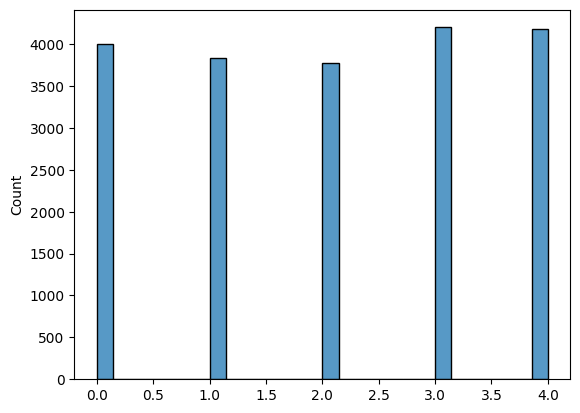

In [252]:
sns.histplot(predictions)
plt.show()

In [258]:
predpred = predictions.copy()

In [259]:
for i in range(len(predpred)):
    predpred[i] = predpred[i] + 1

In [260]:
predictions_df = pd.DataFrame({'predicted':predpred})
print(predictions_df.value_counts()/len(test))

predicted
4            0.21005
5            0.20910
1            0.19985
2            0.19200
3            0.18900
Name: count, dtype: float64


array([[<Axes: title={'center': 'predicted'}>]], dtype=object)

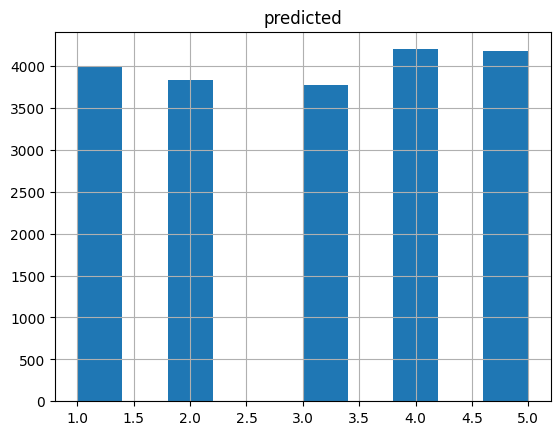

In [261]:
predictions_df.hist()

In [262]:
predictions_df.to_csv('q2_submission.csv',index = False)